# Classification with Decision Trees and Neural Networks

In this notebook, we will predict what the education level based on the content of the post. We will explore 2 approaches: (1) a bag-of-words model then using a decision tree classifier and (2) a bag-of-words model then applying a simple neural network.

In [1]:
import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
df_1 = pd.read_csv("./../assets/data_large_041019.csv", index_col = 0)
df_2 = pd.read_csv("./../assets/data_large_211019.csv", index_col = 0)
df_3 = pd.read_csv("./../assets/data_large_270919.csv", index_col = 0)
df_4 = pd.read_csv("./../assets/data_large_300919.csv", index_col = 0)
df_5 = pd.read_csv("./../assets/data_large.csv", index_col = 0)

In [3]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5]).reset_index(drop = True)
df.fillna("NaN", inplace = True)

# We'll filter out the columns since we're only concerned with the content and education level
df = df[['content', 'education']]

In [4]:
df.sample(10)

,content,education
9331,I am a Carpet Mechanic (installer) W/Over 23-y...,bachelors
41242,SAMANTHA\r\n\r\n\r\nPROFESSIONAL SUMMARY\r\n\r...,high school/GED
61939,"Home and Business Owners,\r\nGet items repaire...",associates
66457,l am looking a job in orange county only you c...,less than high school
93956,"Private clases and interpretation, I've been t...",bachelors
45529,600.00 Weekly\r\nBegan In This Field 35 Yrs Ag...,some college
68648,I am looking for a live-in or live-out caregiv...,masters
38284,I am a licensed electrician with bucket truck ...,some college
16885,Hard Working Male Looking For Some Sort Of Off...,high school/GED
69861,If someone need help with any proyet let not I...,high school/GED


## Data Cleaning

Machine learning models are very sensitive to imbalanced data. For an exaggerated example, imagine training a model to predict dogs and cats. If your training data has 99 images of dogs and only 1 image of a cat, your model will most likely overfit and only predict dogs and still get 99% accuracy.

We will filter and clean our data in preparation for the prediction and become a data janitor.

With our data collection process, some of the posts were repeated. They were either posted in different times or different locations. We'll take a look at all data points that aren't unique in the `content` column.

In [5]:
df[df.duplicated(subset = 'content')].head(10)

,content,education
3,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,bachelors
4,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,bachelors
12,"We will professionally write your resume, so y...",masters
13,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,bachelors
24,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,bachelors
25,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,bachelors
35,Hello. I am looking for office work. I have ex...,bachelors
82,"Hey CL, I'm a 27 year old male trying to make ...",some college
113,Quickbooks and Quicken Bookkeeper\r\n\r\nAvail...,some college
151,I would love to tutor your child to improve hi...,bachelors


Notice that some of the data points were posted at different times or region. However, we want only one instance of that data. So we'll go ahead and remove all documents that have duplicates and keep the first occurance.

In [6]:
df.drop_duplicates(subset = 'content', keep = 'first', inplace = True)
df.reset_index(drop = True, inplace = True) #reset index just makes it cleaner to look at when all processing is done

We removed the duplicates from our dataset. Now, let's take a look at how our data is distributed.

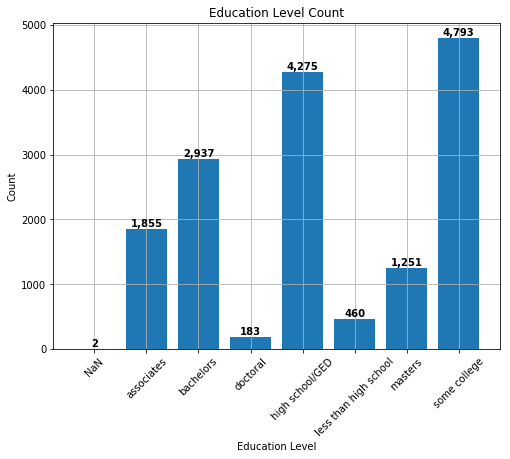

In [7]:
x = []
y = []

# Get the number of occurence of each unique class in our education list
educ_count = df.groupby(['education']).count()['content']
educ_list = list(sorted(df['education'].unique()))

# Store it in x and y for easier use later
for educ in educ_list:
    x.append(educ)
    y.append(educ_count[educ])

# Set figure size
plt.figure(figsize = (8,6))
# Set plot title
plt.title("Education Level Count")
# Set x label
plt.xlabel("Education Level")
# Set y label
plt.ylabel("Count")
# Rotate the x labels so they don't look weird when they overlap
plt.xticks(rotation=45)

# Plot the bar graph of each label's frequency
plt.bar(x, y)

# Plot grid lines
plt.grid()

# Annotate the frequency at the top of each bar
# x - which label id
# y - heigh of bar graph, we add 35 to offset the text location
# s - text
# fontweight - make it bold or italic
# horizontalalignment - alignment of text
for idx, value in enumerate(y):
    plt.text(x = idx, y = value + 35, 
             s = f"{value:,}", fontweight='bold', 
             horizontalalignment='center')

# Add more matplotlib code to your heart's desire to make it look cooler
# But don't add too much

# Show the graph
plt.show()

In [8]:
# If you don't need to plot it
df.groupby(['education']).count()['content']

education
NaN                         2
associates               1855
bachelors                2937
doctoral                  183
high school/GED          4275
less than high school     460
masters                  1251
some college             4793
Name: content, dtype: int64

Here, we notice that we have classes that only have a few examples. We will have some difficulties training a model that can accurately predict these classes. There different approaches for this problem such as downsampling or upsampling but we won't go through it here. For now, we will only select the classes that has at least 1,000 examples.

In [9]:
# List out education levels that we will include
included_educ_level = ['high school/GED',
                       'some college',
                       'associates',
                       'bachelors',
                       'masters']

# Filter out our data and only include samples that are in the selected education levels
df = df[df['education'].isin(included_educ_level)].reset_index(drop = True)

Okay so the distribution seems good enough for our use case. Let's try to take a look at the text and see if we need more preprocessing for it.

## Text Cleaning

After cleaning up our data, we'll dive deeper and look at the text that we have.

In [10]:
df['content'].sample(10, random_state = 237)

1648     If u need my service comercial work\r\n\r\nThi...
11747    Looking for a small job, specifically 5 days a...
13198    Hi there, I'm in need of side work. Caregiving...
10210    2 SKILLED Guys💥\r\nOur Own Tools and Trucks 🛠\...
1451     Exceptionally caring, reliable, male caregiver...
6900     I am looking for a job as a welder's helper. I...
14111    Two person residential electrical sub crew loo...
9025     Currently looking for cash paying security gua...
11589                Outstanding Chef here for your needs.
10495    We are expert skillful men proving many servic...
Name: content, dtype: object

Looks like some of the posts have emojis or weird characters in their text. We can do a simple regex function to filter out each text in the dataframe and replace it with only alphanumeric characters.

In [11]:
df['content'] = df['content'].map(lambda x: re.sub('[^A-Za-z0-9 _.,?!/$]*', '', x))
df['content'].sample(10, random_state = 237)

1648     If u need my service comercial workThis is wha...
11747    Looking for a small job, specifically 5 days a...
13198    Hi there, Im in need of side work. Caregiving,...
10210    2 SKILLED GuysOur Own Tools and Trucks Availab...
1451     Exceptionally caring, reliable, male caregiver...
6900     I am looking for a job as a welders helper. I ...
14111    Two person residential electrical sub crew loo...
9025     Currently looking for cash paying security gua...
11589                Outstanding Chef here for your needs.
10495    We are expert skillful men proving many servic...
Name: content, dtype: object

Let's break down the regex function: <br />
`re.sub(pattern, repl, string)` <br /> <br />
`pattern` is the regular expression that the function will look for to replace. <br />
`repl` is the new string that will replace the `pattern` <br />
`string` is the string that you want to run the pattern matching and replacement.

Now, let's break down the regular expression. <br />
`[^A-Za-z0-9 _.,?!/$]*` <br />
`[]` anything inside the square brace will be characters that will be considered in replacement<br />
`^` Performs a `not` function. We will list down all the characters that we want to keep and perform `not` to take out those that don't match.<br />
`A-Z` All uppercase letters<br />
`a-z` All lowercase characters<br />
`0-9` All numerical characters<br />
` _.,?!/` Space, underscore, period, and other punctuations that we want to keep.<br />
`*` The length of the pattern doens't matter as long as each character matches the criterion.

One thing that machine learning models don't intuitively know is the difference in cases. For us, `attention` is the same as `Attention` or `aTtEnTiOn`. In a bag of words model, this will be separated into 3 different tokens. What we can do is to make every text lowercase to keep it standardized.

You can add the `.lower()` at the end of a string to convert it to lower case. Another solution is to use `.upper()` to make it all upper case but that would sound like an internet argument.

In [12]:
df['content'] = df['content'].map(lambda x: x.lower())
df['content'].sample(10, random_state = 237)

1648     if u need my service comercial workthis is wha...
11747    looking for a small job, specifically 5 days a...
13198    hi there, im in need of side work. caregiving,...
10210    2 skilled guysour own tools and trucks availab...
1451     exceptionally caring, reliable, male caregiver...
6900     i am looking for a job as a welders helper. i ...
14111    two person residential electrical sub crew loo...
9025     currently looking for cash paying security gua...
11589                outstanding chef here for your needs.
10495    we are expert skillful men proving many servic...
Name: content, dtype: object

In most cases, this preprocessing is enough to process your data and use in a machine learning model.

# Classification Models

Now that our data is cleaned up, we'll first discuss how we'll convert these texts to features that we can feed to our machine learning model. 

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import graphviz

## FEATURES

### Count Vectorizer

<img src="./../assets/images/bow-image.png" style="width: 300px;">

A bag-of-words model puts every word in your document into a bag (vector) and returns the bag. The most common bag of words model is the Count Vectorizer where you count each occurence of a word in a document. The visual above represents how a Count Vectorizer works. It's easy to use however this removes the sentence structure of the document.

In [14]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english')

features = vector.fit_transform(df['content'].head(5))

The dataframe below is how your data would look like once it is converted by the Count Vectorizer. Each column represents a token. For big matrices, the vectorizer converts the data into a sparse matrix to reduce the amount of memory used. You can revert it to an array with the `.todense()` function.

In [15]:
pd.DataFrame(features.todense())

,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,223
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,2,0,1,2,...,0,0,0,0,0,0,0,1,0,0
4,1,0,1,1,0,0,0,0,0,0,...,1,0,2,0,0,0,0,0,2,3


You can get the features with the `.vocabulary_` function.

In [16]:
#vector.vocabulary_

You can also see read more about the Count Vectorizer documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

## LABELS

### Label Encoding
We will convert each label into a numerical index. From 'highschool', 'college', and 'masters', we will convert it to '0', '1', and '2'.

In [17]:
encoder = LabelEncoder()
target = encoder.fit_transform(df['education'])

target = pd.DataFrame({'education':df['education'].values,
                       'target':target})
target.sample(10)

,education,target
5682,associates,0
5296,associates,0
2987,masters,3
9673,bachelors,1
9750,some college,4
5170,masters,3
4305,associates,0
10829,bachelors,1
3014,associates,0
7731,bachelors,1


Now let's write out the code again to clean it up.

In [18]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 10000)

features = vector.fit_transform(df['content'])
# Create list of feature index to token
token_list = {b:a for a,b in vector.vocabulary_.items()}

In [19]:
sorted_tokens = []
for a in sorted(token_list):
    sorted_tokens.append(token_list[a])

In [20]:
encoder = LabelEncoder()

target = encoder.fit_transform(df['education'])
# Get the list of labels
labels = list(encoder.classes_)

To train our model, we'll split the data into a training and test set. We train the model on our training data and validate the performance of the model on our test set.

For our neural network, we'll split the data into training, validation, and test set. The validation set will be used as a way to validate checkpoints in our neural network training to prevent overfitting.

In [21]:
X_train_full, X_test, y_train_full, y_test = train_test_split(features, target, test_size = 0.2, shuffle = True)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.25)

## Decision Tree

<img src="./../assets/images/decision_tree.png" style="width: 600px;">

Decision Trees are created by the data into groups based on which feature can differentiate each node. You can change the parameters of the decision tree such as the maximum depth of the tree and the minimum samples in a node before it can be split. A Decision Tree learns by splitting your data based on the features and labels.

<img src="./../assets/images/dtc1.png" style="width: 600px;">


In [22]:
clf = DecisionTreeClassifier(max_depth = 20,
                             min_samples_split = 10,
                             criterion = 'entropy')

In [23]:
clf.fit(X_train_full, y_train_full)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

We can check how well our model performed both in the training and test data.

In [24]:
train_score = clf.score(X_train_full, y_train_full)
test_score  = clf.score(X_test, y_test)

print(f"Training score:\t{train_score*100:.2f}%")
print(f"Testing score:\t{test_score*100:.2f}%")

Training score:	51.49%
Testing score:	39.70%


We can also retrieve the most important features from the data.

In [25]:
print("Top 10 most important features:")
for a in np.argsort(clf.feature_importances_)[::-1][:10]:
    print(" -",token_list[a])

Top 10 most important features:
 - business
 - degree
 - design
 - marketing
 - professional
 - work
 - teacher
 - masters
 - mba
 - im


In [26]:
def get_prediction(text):
    sample_vec = vector.transform([text])
    predict = clf.predict(sample_vec)
    predict_class = encoder.inverse_transform(predict.astype(int))
    
    print(text,"\n")
    print(f"Predict:\t{predict_class[0]}")

get_prediction(df['content'].iloc[10])
print(f"Truth \t\t{df['education'].iloc[10]}")

my name is melissa i specialize in housekeeping services and have good references. i am reliable and efficient. no job is too much. i am located in truth or consequences . message me if you need housekeeping. thank u 

Predict:	some college
Truth 		high school/GED


With the new update in scikit learn, you can now create pdfs of the tree generated by your model.

We would need to download graphviz, export the file, and set it as one of our PATH variables below.</br>
https://www.graphviz.org/download/

In [27]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/graphviz/release/bin'

dot_data = tree.export_graphviz(clf, out_file=None, feature_names = sorted_tokens, 
                                filled = True, class_names = encoder.classes_) 
graph = graphviz.Source(dot_data) 
graph.render("nlp") 

'nlp.pdf'

## Neural Network
<img src="./../assets/images/nn.jpg" style="width: 600px;">

The Neural Network is a series of layers of nodes that are connected. The model learns by updating its parameters based on 'how wrong' the model is. Model training follows this series of steps:<br/>

- Model predicts the output
- Calculate the loss
- Propagate the loss through the entire network
- Update the weights
- Repeat

For this exercise, we will be using PyTorch.

In [28]:
import numpy as np

import torch
import torchvision

from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as utils

We first need to check if a GPU is available.

In [29]:
cuda = torch.cuda.is_available()

if cuda:
    print("GPU detected. Training with GPU")
else:
    print("No GPU detected. Training with CPU")

GPU detected. Training with GPU


PyTorch uses its own data structure called Tensor (which is similar to how other deep learning frameworks call it). We need to convert our data to Tensors.

In [30]:
tensor_X_train = torch.stack([torch.Tensor(row.todense()) for row in X_train])
tensor_y_train = torch.tensor(y_train)

tensor_X_valid = torch.stack([torch.Tensor(row.todense()) for row in X_valid])
tensor_y_valid = torch.tensor(y_valid)

tensor_X_test = torch.stack([torch.Tensor(row.todense()) for row in X_test])
tensor_y_test = torch.tensor(y_test)

We then load the our data into a data loader that will create the mini-batches that we will feed into our network.

In [31]:
traindataset = utils.TensorDataset(tensor_X_train, tensor_y_train)
trainloader = utils.DataLoader(traindataset, batch_size = 32, shuffle = True)

validdataset = utils.TensorDataset(tensor_X_valid, tensor_y_valid)
validloader = utils.DataLoader(validdataset, batch_size = 32, shuffle = True)

testdataset = utils.TensorDataset(tensor_X_test, tensor_y_test)
testloader = utils.DataLoader(testdataset, batch_size = 32)

Now, we can define our neural network! To build a simple neural network class, we need to define the `__init__` and `forward` function. <br/>

In the `__init__` function, we define the layers and processes of our network: <br/>

`nn.Linear()` is the hidden layer in the neural network. It takes in the input and output size. We create 3 different hidden layers. Notice that the first hidden layer's input size is equivalent to the number of features in our data. The last hidden layer has output size equivalent to the number of classes of our data.  <br/>
`nn.Dropout()` is a function that randomly turns off certain nodes. With this, the model becomes more robust and less prone to overfit.

In the `forward` function, we define how our model intakes, calculates, and outputs our data. There are 2 functions that we introduce here as well:<br/>

`F.relu()` performs the activation function ReLU (Rectified Linear Unit) on our model.<br/>
`F.log_softmax()` returns the LogSoftmax of the output and returns the class probabilty.

In [32]:
# Model must always inherit the nn.Module class
class Classifier(nn.Module):
    # Define the init function
    def __init__(self):
        super().__init__()
        
        # Create the first hidden layer with input 10,000 and output 2,000
        self.fc1 = nn.Linear(10000, 2000)
        # Create the second hidden layer with input 2,000 and output 500
        self.fc2 = nn.Linear(2000, 500)
        # Create the third hidden layer with input 500 and output 5
        self.fc3 = nn.Linear(500, 5)
        
        # Define the dropout function
        self.drop = nn.Dropout(0.5)
        
    # Define the forward function
    def forward(self, x):
        # Reshape the data
        x = x.view(x.shape[0], -1)
        # Feed the input data to the first hidden layer, apply dropout, and then apply the ReLU activation
        x = F.relu(self.drop(self.fc1(x)))
        # Same process as applies but using the second hidden layer
        x = F.relu(self.drop(self.fc2(x)))
        # Feed the features into the last hidden layer and feed it to a log soft max
        x = F.log_softmax(self.fc3(x), dim = 1)
        # Return output
        return x

Now that the model has been defined, we now need to define the loss function for our model and the optimizer.<br/>

The `loss function` calculates 'how wrong' our model is based on the ground truth values. In our example, we will use the __Negative Loss Likelihood function__.<br/>
The `optimizer` defines how you calculate the gradients that will update the neural network parameters. __Adam__ is one of the popular optimizers.

In [33]:
# Instantiate our model
model = Classifier()
# Define our loss function
criterion = nn.NLLLoss()
# Define our optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0003)

Next we will define our training loop. The training loop will run over n number of epochs. Earlier, we mentioned that neural networks tend to overfit the data, which is why we add a validation set in our training. The validation set is similar to the test set where we select the model that has the highest validation set. The difference between the validation and test set is the model never went through the test set. Since we're selecting our model based on the validation set, the validation set is, in a way, a bias in our model.

In [34]:
# Define how many epochs we want
epochs = 10

# Set the best loss as infinity and best_model as none
best_loss = np.inf
best_model = None

# Create empty arrays for our training losses for analysis
train_losses = []
valid_losses = []

# If we are using a GPU, import the model to the GPU
if cuda:
    model = model.cuda()
    
# Training loop
for e in range(epochs):
    # Set training loss for this epoch as 0
    train_loss = 0.
    
    # Set the model to `train` mode
    # This will let the functions that are important in training but
    # not validation to activate (i.e. Dropouts)
    model.train()
    
    ####################
    ##### TRAINING #####
    ####################
    
    # Loop for the mini batches using our dataloader
    for feat, labels in trainloader:
        # If we are using a GPU, move the features and the labels to the GPU
        if cuda:
            feat, labels = feat.cuda(), labels.cuda()
            
        # Get the output of the model
        log_ps = model(feat)
        
        # Calculate the loss for this mini batch size
        loss = criterion(log_ps, labels.long())
        
        # Zero out the gradients. By default, the gradients accumulate
        # which is convenient for RNNs
        optimizer.zero_grad()
        
        # Propage the loss to our model
        loss.backward()
        
        # Update our models weights
        optimizer.step()
        
        # Get the training loss for this mini batch
        train_loss += loss.item()
        
    # Get the average training loss for the entire training data for this epoch
    train_loss /= len(trainloader)
    train_losses.append(train_loss)
    
    ####################
    #### VALIDATION ####
    ####################
    
    # Set the valid loss
    valid_loss = 0.
    
    # Turn the model to eval mode so dropouts are turned off
    model.eval()
    
    # Loop for the validation set
    for feat, labels in validloader:
        # Move to GPU
        if cuda:
            feat, labels = feat.cuda(), labels.cuda()
        
        # Calculate predictions
        log_ps = model(feat)
        
        # Get loss function
        loss = criterion(log_ps, labels.long())
        
        # Get the loss for the mini batch
        valid_loss += loss.item()
        
        # Notice that we didn't zero out the gradients, propagate the loss
        # nor did we update the weights. The validation loop is merely for
        # evaluating the performance of our model
        
    # Get the average validation loss
    valid_loss /= len(validloader)
    valid_losses.append(valid_loss)
    
    # Print the training loss and validation loss of this epoch
    print(f"Epoch {e}: Training loss: \t{train_loss:.6f}\tValid loss: \t\t{valid_loss:.6f}")
    
    # If the validation loss improved, we save the model as the best model
    if valid_loss < best_loss:
        print("Validation loss improved... Saving model")
        best_loss = valid_loss
        best_model = model

model = best_model

Epoch 0: Training loss: 	1.390400	Valid loss: 		1.287995
Validation loss improved... Saving model
Epoch 1: Training loss: 	1.057799	Valid loss: 		1.297287
Epoch 2: Training loss: 	0.686436	Valid loss: 		1.526657
Epoch 3: Training loss: 	0.405262	Valid loss: 		1.853529
Epoch 4: Training loss: 	0.228052	Valid loss: 		2.103699
Epoch 5: Training loss: 	0.151096	Valid loss: 		2.354072
Epoch 6: Training loss: 	0.111097	Valid loss: 		2.555210
Epoch 7: Training loss: 	0.091499	Valid loss: 		2.682097
Epoch 8: Training loss: 	0.066871	Valid loss: 		2.791855
Epoch 9: Training loss: 	0.053388	Valid loss: 		3.059007


Now, if you have a GPU, you can make a cup of coffe while you wait for the training loop. If you don't, might be good time watch an episode of a series you've been following.

Afterwards, we'll plot and see our training and validation loss.

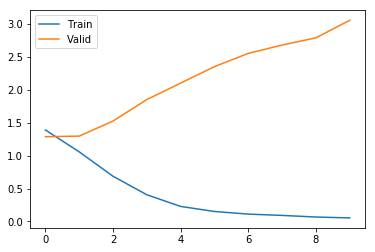

In [35]:
plt.plot(train_losses, label = 'Train')
plt.plot(valid_losses, label = 'Valid')
plt.legend()
plt.show()

In [49]:
def model_predict(text, model):
    # Convert our text to the vector representation
    if type(text) == str:
        text = vector.transform([text])
    # Convert it into a torch Tensor
    text = torch.Tensor(text.todense())
    # Move to GPU if you have GPU
    if cuda:
        model = model.cuda()
        text = text.cuda()
        
    # Predict probabilities
    predict = model(text)
    # Move the predictions to cpu
    predict = predict.cpu().detach().numpy()[0]
    # Get the prediction with highest probability
    predict = predict.argmax()
    predict_class = encoder.inverse_transform([predict.astype(int)])
    return predict

model_predict("I have a degree", model)

3

Now we have a working model. Let's see it's accuracy in the training and test data.

In [50]:
correct_count = 0
for feat, val in tqdm(zip(X_train, y_train), total = len(y_train)):
    if model_predict(feat, model) == val:
        correct_count += 1

print(f"Model train accuracy: {correct_count*100/len(y_train):.2f}%")

for feat, val in tqdm(zip(X_test, y_test), total = len(y_test)):
    if model_predict(feat, model) == val:
        correct_count += 1

print(f"Model test accuracy: {correct_count*100/len(y_test):.2f}%")

100%|██████████████████████████████████████████████████████████████████████████| 9066/9066 [00:09<00:00, 970.56it/s]


Model train accuracy: 99.65%


100%|██████████████████████████████████████████████████████████████████████████| 3023/3023 [00:03<00:00, 983.80it/s]


Model test accuracy: 47.27%


It's a lot to take in. Luckily, scikit-learn has very simple implementation. MLPClassifier is short for Multi Layer Perceptron Classifier which is another term for the simple feed forward neural network.

In [42]:
from sklearn.neural_network import MLPClassifier

In [43]:
mlp = MLPClassifier(hidden_layer_sizes = (2000, 500),
                    activation = 'relu',
                    solver = 'adam',
                    batch_size = 32,
                    learning_rate_init = 0.0003,
                    max_iter = 1,
                    shuffle = True,
                    verbose = 1)

In [ ]:
mlp.fit(X_train, y_train)

In [ ]:
mlp.score(X_test, y_test)